In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

## Load the dataset

We are loading the [Iris](https://www.kaggle.com/datasets/uciml/iris) flower classification dataset (downloaded from [Kaggle](https://www.kaggle.com/), see `iris.csv` in this directory). This is one of the best-known pattern recognition tasks. It is a simple task, but the classes are not linearly separable. 

We use the `pd.get_dummies` function to turn the categorical target variable (the species of the flower) into a one-hot encoded numerical vector. We then convert the dataset into a numpy array.

In [2]:
df = pd.read_csv('iris.csv', index_col=0)
df = pd.get_dummies(df)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species_Iris-setosa,Species_Iris-versicolor,Species_Iris-virginica
Id,,,,,,,
1,5.1,3.5,1.4,0.2,1,0,0
2,4.9,3.0,1.4,0.2,1,0,0
3,4.7,3.2,1.3,0.2,1,0,0
4,4.6,3.1,1.5,0.2,1,0,0
5,5.0,3.6,1.4,0.2,1,0,0


In [3]:
data_raw = df.to_numpy()
data_raw.shape

(150, 7)

The numpy array has 150 data points, each with 7 values (the first 4 are inputs, the other 3 are outputs of our classification task). Before we do any further processing, we randomly split the dataset into training and testing data. We split the data evenly with respect to the classes, such that the number of samples of each class in the training and testing data are equal. 

In [4]:
sample = lambda a, b: random.sample(range(a, b), 40)
train_idxs = sample(0, 50) + sample(50, 100) + sample(100, 150)
test_idxs = [idx for idx in range(150) if idx not in train_idxs]

We then pre-process the data by diving each of the four features by its respective maximum value in the training data. 

In [5]:
# standardize data: divide each feature by maximum value (computed on training data only)
data = data_raw.copy()
data[:,:4] = data[:,:4] / data[train_idxs,:4].max(axis=0)

Reservoir computing works with temporal signals, but we currently do not have any time series data. Instead, each sample is a four dimensional vector $u \in \mathbb{R}^4$. We can turn each sample into a temporal signal by encoding the values into the frequencies of the sine function: $u_i \mapsto \sin(2\pi u_i t) \text{ for } i \in \{1,\ldots,4\}$. We then sample the sine function at fixed intervals to yield 500 samples. 

In [6]:
timesteps = np.arange(0, 50, 0.1)
u = np.array([
    np.vstack([np.sin(timesteps*2*np.pi*pt[i]) for i in range(4)]).T
    for pt in data[:,:4]
])
y = np.array([data[:,4:]] * len(timesteps)).swapaxes(0, 1)

Now, our dataset contains 150 samples, each of which is a time series with 500 discrete time steps. This makes the inputs `u` and the outputs `y` 3-dimensional data arrays (or tensors):

In [7]:
u.shape, y.shape

((150, 500, 4), (150, 500, 3))

Below we plot some input time series:

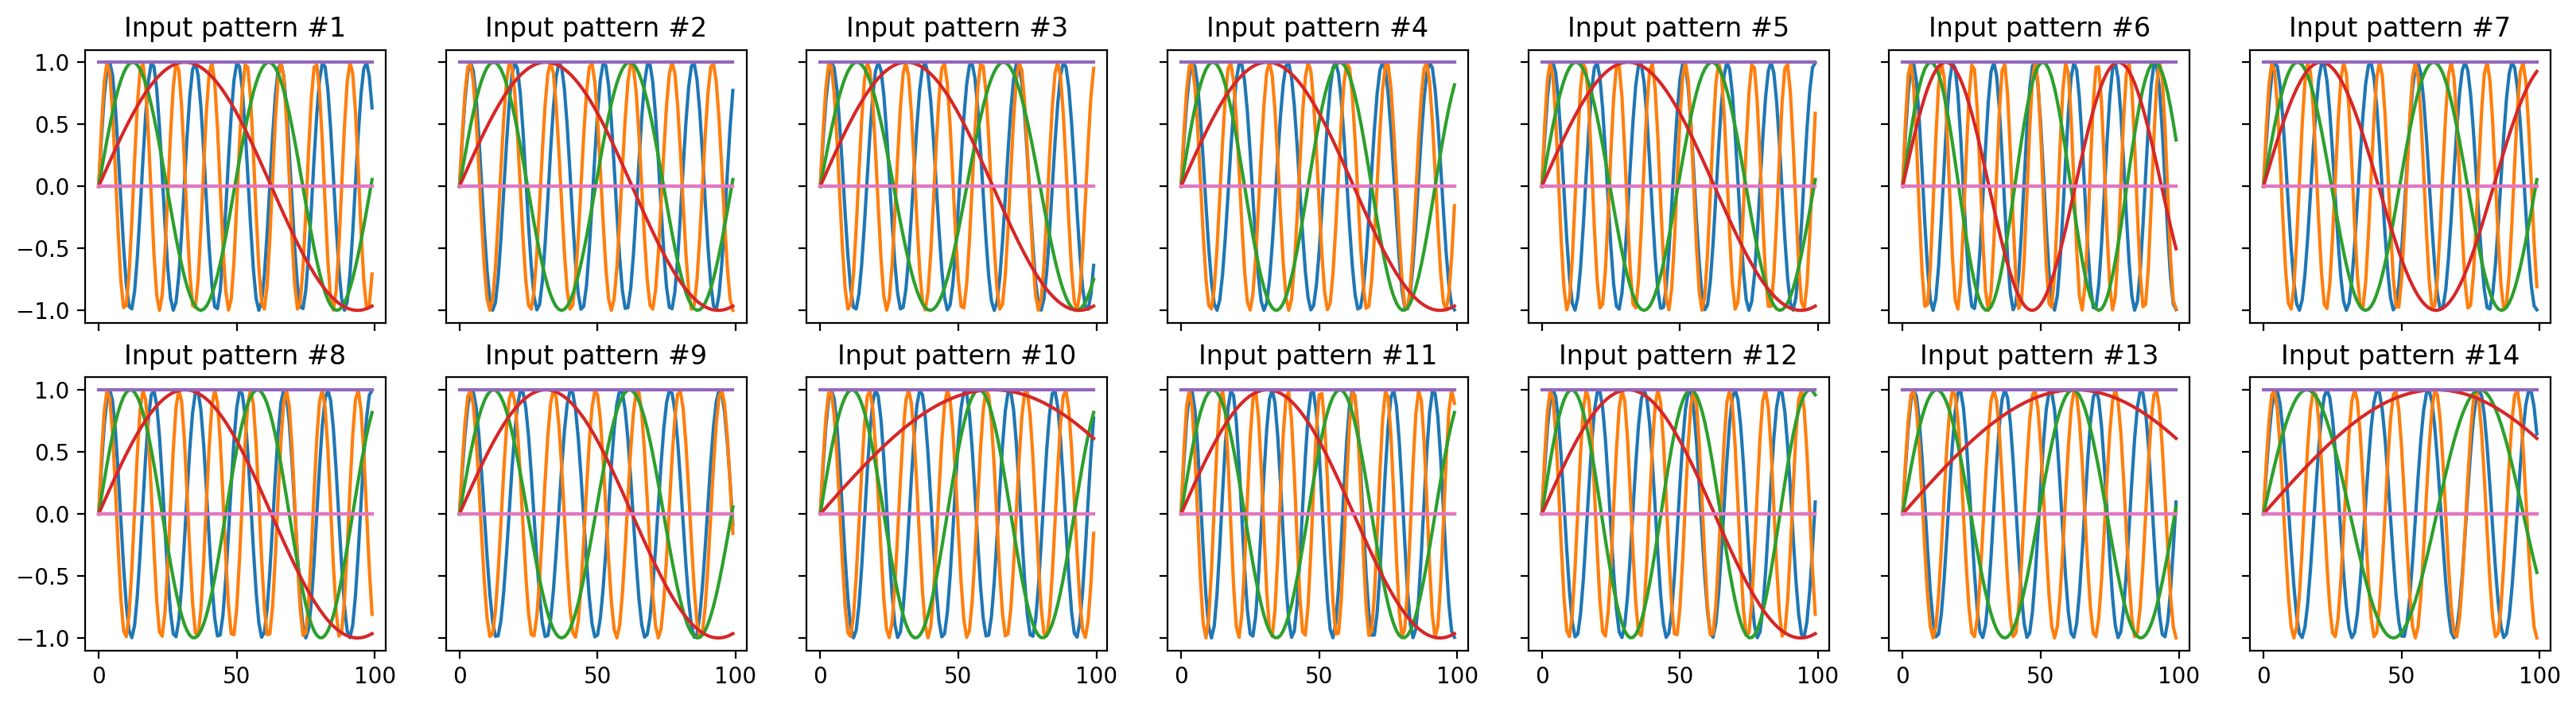

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=7, sharex=True, sharey=True, figsize=(20, 5), dpi=200)
for i in range(2):
    for j in range(7):
        axs[i][j].set_title(f'Input pattern #{i*7+j+1}')
        axs[i][j].plot(u[i*7+j,:100])
        axs[i][j].plot(y[i*7+j,:100])

Finally, we split the temporal signals into the training and testing datasets:

In [9]:
u_train = u[train_idxs]
y_train = y[train_idxs]
u_test = u[test_idxs]
y_test = y[test_idxs]

## Set up the reservoir

Now that the input signal is prepared, we will feed this signal to the reservoir. In physical reservoir computing, this reservoir is a physical system, but for this demonstration we will be modeling the reservoir in simulation with an Echo State Network, see the `reservoir.py` file for implementation details. 

In [10]:
from reservoir import Reservoir

In simulation, we can easily create a new reservoir with a set of parameters:

- `n_neurons`: number of neurons in the reservoir, corresponds to the dimension of the reservoir, or its computational capacity/power
- `rhow`: the spectral radius of the reservoir, corresponds to the dynamical regime of the reservoir. When the input signal is ommitted, for small values, activity in the reservoir will die out quickly while for large values, activity in the reservoir will tend to explode (see the paper for details).
- `leak_range`: leak rate of the reservoir's update equations. This tunes the *timescale* of the reservoir. A lower leak rate will lead to a slower reservoir. In this implementation, the leak rate is specified by two parameters, the minimum $a$ and maximum $b$ leak rate, and the actual leak rate of each neuron is sampled from the uniform distribution $\mathcal{U}(a,b)$.

In a physical setup, these parameters cannot be chosen as easily as in simulation. However, physical reservoirs often can be tuned in ways that correspond to one of the three parameters explained above. Therefore, we have chosen to set up the simulation as it is. We will first use standard values for the reservoir and see how it performs. Afterwards, we will tune the reservoir to improve the performance on our classification task.

In [11]:
reservoir = Reservoir(n_inputs=u_train.shape[2], n_neurons=20, rhow=1.25, leak_range=(0.1, 0.3))

spectral radius: 1.250


## Collect reservoir states

Now that the reservoir has been created, we feed the input signal into the reservoir. To do this, we simply concatenate all input sequences and feed them into the reservoir. We can do this because we will discard the initial transient of each time series anyway (the so-called washout period, see below).

In [12]:
print(f'{u_train.shape} -> {np.concatenate(u_train).shape}')

(120, 500, 4) -> (60000, 4)


We then pass the training input signal to the reservoir and collect the states:

In [13]:
X_train = reservoir.forward(np.concatenate(u_train), collect_states=True)
X_train.shape

(60000, 20)

## Train the readout map

Now that we have the collected state matrix $X_{train}$ (`X_train`), we can use the training labels $Y_{train}$ (`y_train`) compute the readout map $\hat W^{out}$ which maps the reservoir state to the output vector. We do this using ridge regression:
$$
\hat W^{out} = (R + \alpha I)^{-1} P
$$
where $R=X_{train}^T X_{train}$ is the state correlation matrix, $P=X_{train}^T Y_{train}$ is the state-output cross-correlation matrix and $\alpha$ is the regularization parameter.

Note that we will "wash out" the initial time steps of each time series to ignore effects to due initial conditions of the reservoir. 

In [14]:
alpha = 1e-3
T_washout = 100

# drop states during the initial washout period of each time series
X_washout = X_train.reshape((u_train.shape[0], u_train.shape[1], -1))[:, T_washout:, :]
X = np.concatenate(X_washout)
Y = np.concatenate(y_train[:, T_washout:, :])
# state correlation matrix
R = X.T @ X
# state-output cross-correlation matrix
P = X.T @ Y
# ridge regression: state -> output
wout = np.linalg.inv((R + alpha * np.eye(X_train.shape[1]))) @ P

## Evaluate the performance

Now that we computed the readout map, we can apply it to the reservoir states that we collected for the training data, in order to evaluate the accuracy of our reservoir classifier. 

In [15]:
y_pred_train = X_train @ wout

We can evaluate the accuracy in multiple ways. In the simplest approach, we can take the class that the reservoir predicts for every single time step and compare that to the ground truth from our dataset.

In [16]:
def accuracy_elementwise(ypred, ytrue):
    # compute accuracy at each time step
    yp = ypred.reshape(-1, ytrue.shape[2]).argmax(axis=1)
    yt = ytrue.reshape(-1, ytrue.shape[2]).argmax(axis=1)
    return np.sum(yp == yt) / yp.shape[0]

In [17]:
print(f'Training accuracy: {accuracy_elementwise(y_pred_train, y_train):.2%} (per time step)')

Training accuracy: 51.38% (per time step)


But since we want to classify the entire time series as a whole, and not each individual time step, we can also average the output of the reservoir for each time series and use the average as the class predicted by the reservoir for this time series. We would expect this to perform much better. 

In [18]:
def accuracy(ypred, ytrue):
    # compute accuracy by averaging the predicted class over the whole time series
    yp = ypred.reshape(ytrue.shape).mean(axis=1).argmax(axis=1)
    yt = ytrue[:,0,:].argmax(axis=1)
    return np.sum(yp == yt) / yp.shape[0]

In [19]:
print(f'Training accuracy: {accuracy(y_pred_train, y_train):.2%} (per time series)')

Training accuracy: 72.50% (per time series)


We have evaluated the training accuracy now, but we also need to evaluate the performance of the reservoir on unseen examples. To do this, we feed the testing input to the reservoir, collect the reservoir states into the matrix $X_{test}$ and apply the readout matrix $\hat W^{out}$ to this matrix in order to get the predicted output on the testing data:

In [20]:
X_test = reservoir.forward(np.concatenate(u_test), collect_states=True)
y_pred_test = X_test @ wout

And we report both accuracy metrics for the testing data:

In [21]:
print(f'Testing accuracy:  {accuracy_elementwise(y_pred_test, y_test):.2%} (per time step)')
print(f'Testing accuracy:  {accuracy(y_pred_test, y_test):.2%} (per time series)')

Testing accuracy:  53.95% (per time step)
Testing accuracy:  86.67% (per time series)


In summary, this is how our reservoir performed on the classification task:

In [23]:
print(f'Training accuracy: {accuracy(y_pred_train, y_train):.2%} (per time series)')
print(f'Testing accuracy:  {accuracy(y_pred_test, y_test):.2%} (per time series)')

Training accuracy: 72.50% (per time series)
Testing accuracy:  86.67% (per time series)
